# Titanic Binary Classification Tensorflow vs Random Forest Classifier

In [274]:
import timeit

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Keras
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, PReLU
from keras.utils import to_categorical 

In [275]:
#Supress Notebook Warning
import warnings
warnings.filterwarnings('ignore')

# Load Data to Dataframe

In [276]:
#Load Titanic Dataset
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

## Training Data EDA

### Training Data

In [277]:
#View Training
df_train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [278]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [279]:
df_train.isna().sum()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [280]:
df_train.describe()

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [281]:
#Check for Imbalance data.
df_train['survived'].value_counts()

0    384
1    243
Name: survived, dtype: int64

<AxesSubplot: ylabel='sex'>

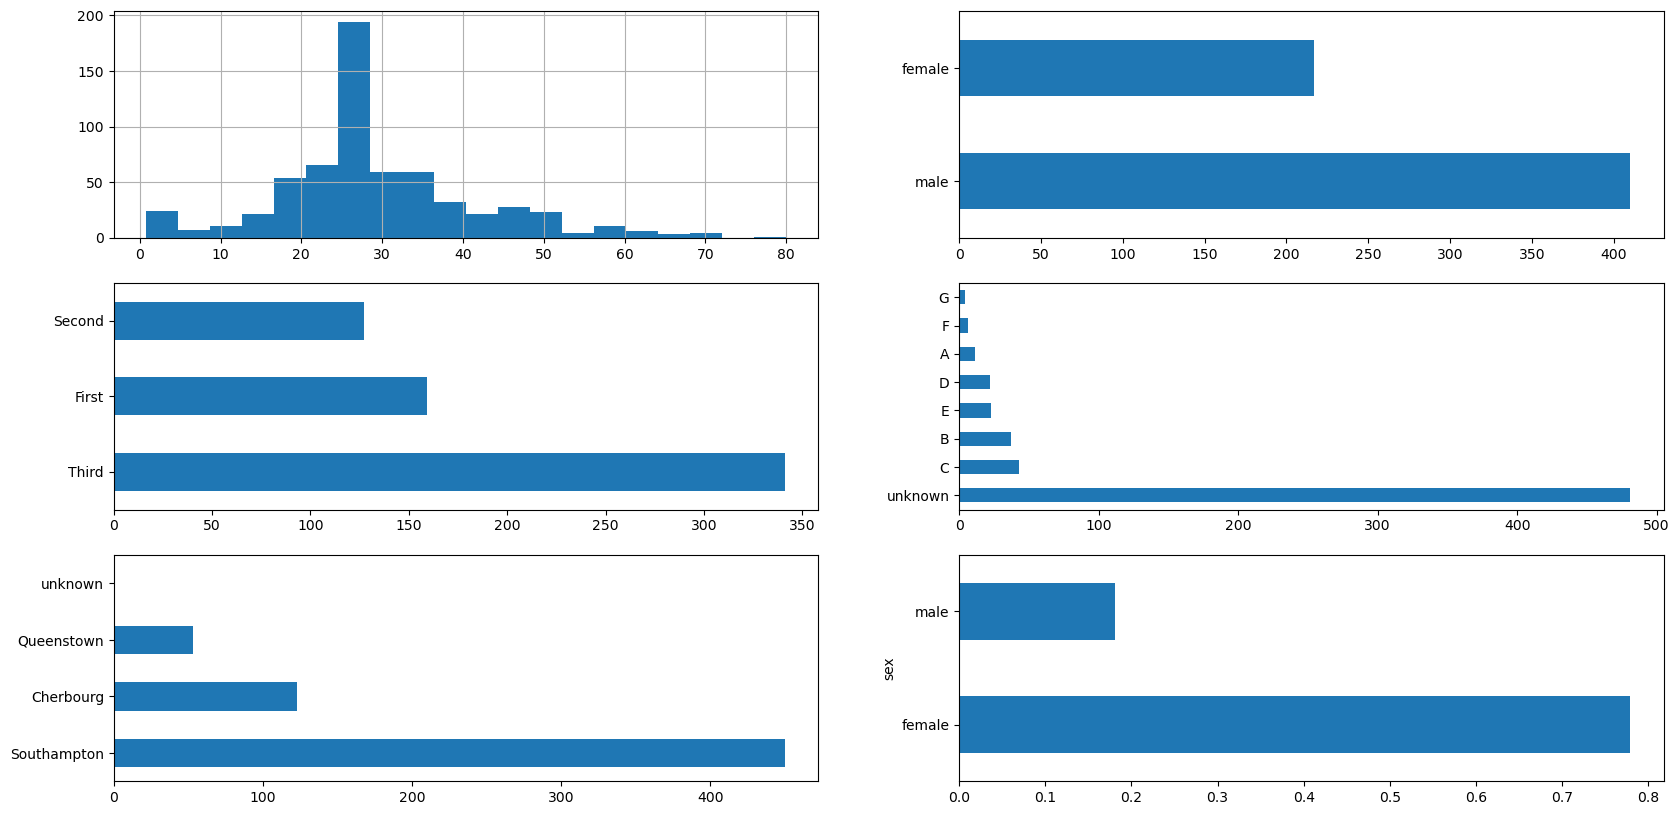

In [282]:
fig,ax = plt.subplots(3,2,figsize=(20,10))
df_train['age'].hist(bins=20,ax=ax[0,0])
df_train['sex'].value_counts().plot(kind='barh',ax=ax[0,1])
df_train['class'].value_counts().plot(kind='barh',ax=ax[1,0])
df_train['deck'].value_counts().plot(kind='barh',ax=ax[1,1])
df_train['embark_town'].value_counts().plot(kind='barh',ax=ax[2,0])
df_train.groupby('sex')['survived'].mean().plot(kind='barh',ax=ax[2,1])

From above analysis :
1. Training data is not balanced. We will do SMOTE after Train test split
2. Most of the passenger population are male with age in their 20ish
3. There are more Third class passenger than first or second
4. Lot's of deck information are not recorded. (Looking at the big number of Unknown deck)
5. Most of the passenger embarked from southampton
6. Female has a higher chance of survival than male.

## X & y Split 

In [283]:
def X_y_split(df):
    X = df_train.drop(['survived'],axis=1)
    y = df_train[['survived']]
    return X,y.astype('float32')

In [284]:
X,y = X_y_split(df_train)

## Encode X data

In [285]:
df_train.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


#### Prepare Functions to Encode X Data

In [286]:
import category_encoders as ce

def binary_enc(X,cols):
    ce_binary = ce.BinaryEncoder(cols=cols)
    return ce_binary.fit_transform(X)

def onehot_enc(X,cols):
    ce_onehot = ce.OneHotEncoder(cols=cols)
    return ce_onehot.fit_transform(X)

In [287]:
def enc_X(X):
    binary = ['sex','alone']
    one_hot = ['embark_town','class','deck']
    X_enc = binary_enc(X,binary)
    X_enc = onehot_enc(X_enc,one_hot)
    return X_enc.astype('float32')

In [288]:
X_enc = enc_X(X)
X_enc.head()

,sex_0,sex_1,age,n_siblings_spouses,parch,fare,class_1,class_2,class_3,deck_1,...,deck_5,deck_6,deck_7,deck_8,embark_town_1,embark_town_2,embark_town_3,embark_town_4,alone_0,alone_1
0,0.0,1.0,22.0,1.0,0.0,7.250000,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,38.0,1.0,0.0,71.283302,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,26.0,0.0,0.0,7.925000,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,35.0,1.0,0.0,53.099998,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,28.0,0.0,0.0,8.458300,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Prepare Tensorflow Model

In [289]:
#Get X Input Shape
inp_shape = len(X_enc.axes[1])

In [290]:
def keras_model():
    model = Sequential()
    model.add(Dense(inp_shape * 2,input_shape=(inp_shape,),activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

## Balancing Dataset

In [291]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train,X_test,y_train,y_test = train_test_split(X_enc, y, test_size=0.33, random_state=42)
sm = SMOTE(random_state=44)  #Data is not balanced in the EDA check hence we need to balanced the data
X_train_o,y_train_o = sm.fit_resample(X_train, y_train)


In [292]:
X_train_o.shape

(510, 23)

In [293]:
y_train_o.shape

(510, 1)

In [294]:
y_train_o.value_counts()

survived
0.0         255
1.0         255
dtype: int64

## Train tensorflow Model

In [295]:
start_time = timeit.default_timer()
model=keras_model()
model.fit(X_train_o, y_train_o, epochs=20)
end_time = timeit.default_timer()
print (f'Total Runtime Train using Keras x Tensorflow : {end_time-start_time} secs')

Epoch 1/20
 6/16 [==========>...................] - ETA: 0s - loss: 1.0033 - accuracy: 0.4844

2023-04-10 10:39:37.204034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 13ms/step - loss: 0.7931 - accuracy: 0.5745
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.5971 - accuracy: 0.7118
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.5390 - accuracy: 0.7863
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.5291 - accuracy: 0.7549
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 0.5151 - accuracy: 0.8118
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4972 - accuracy: 0.8176
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4899 - accuracy: 0.8137
Epoch 8/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4766 - accuracy: 0.8098
Epoch 9/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4694 - accuracy: 0.8176
Epoch 10/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4654 - accuracy: 0.8137
Epoch 11/20
16/16 [==========

In [296]:
model.evaluate(X_test,y_test,verbose=0)

2023-04-10 10:39:39.185677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.4849368929862976, 0.8019323348999023]

## Evaluate tensorflow model 

In [297]:
df_eval.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [298]:
X_eval,y_eval = X_y_split(df_eval)

In [299]:
X_eval = enc_X(X_eval)

In [300]:
model.evaluate(X_eval,y_eval,verbose=0)

[0.427184134721756, 0.8165869116783142]

# Train Random Forest Classifier

## Define method for Random Forest Classifier with Hyperparameter

In [301]:
def get_confusion_matrix(y_test,y_pred):
    return pd.crosstab(np.ravel(y_test),y_pred,rownames=['Actual'],colnames=['Predicted'])

In [302]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
def rfc_hyperparameter(X,y,folds):
    start_time = timeit.default_timer()
    tune_param = {
        'n_estimators':np.array([100,200,300]),
        'max_depth' : np.array([None,101,151]),    
        'min_samples_split' : np.array([3,4,6]),
        'min_samples_leaf' : np.array([2])
    }    
    grid = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1),param_grid = tune_param,
                        cv=folds,n_jobs= -1).fit(X,np.ravel(y)) 
    
    y_predict = grid.predict(X)
    end_time = timeit.default_timer()
    print (f'Total Runtime Training using RFC model: {end_time-start_time} secs')
    return grid, classification_report(y,y_predict,output_dict=True),classification_report(y,y_predict,output_dict=False),get_confusion_matrix(y,y_predict)

## Start Train RFC Model

In [303]:
rfc,clscore,clscore_print,conf_matrix= rfc_hyperparameter(X_train_o,y_train_o,5)

Total Runtime Training using RFC model: 5.986218958000336 secs


In [304]:
print(clscore_print)

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       255
         1.0       0.95      0.91      0.93       255

    accuracy                           0.93       510
   macro avg       0.93      0.93      0.93       510
weighted avg       0.93      0.93      0.93       510



## Evaluate RFC Model

In [305]:
y_pred_ev = rfc.predict(X_eval)
print(classification_report(y_eval,y_pred_ev,output_dict=False))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       384
         1.0       0.86      0.79      0.83       243

    accuracy                           0.87       627
   macro avg       0.87      0.86      0.86       627
weighted avg       0.87      0.87      0.87       627



# Conclusion

1. Using deep learning we are able to produce a model with accuracy 80+ % with a shorter period of time (2.09 secs)
2. Random Forest model produce the highest accurarcy (90+%) during the data training but it dropped to 87% when we feed the model with the Evaluation data.
3. Although the accuracy is the highest, RFC need almost 3x duration to train the model comparing with the Tensorflow deep learning